# Election Analysis by Identity

The purpose of this notebook is to experiment with the [CCES 2018 election survey data](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910/DVN/ZSBZ7K) of 50,000 respondents. 
This 'target' of this analysis will be the vote in the 2016 Presidential Election. 

There are many vectors by which we may break down the results of an election - and nearly as many reasons to do so. In 
order for parties and candidates to succeed at the polls, they must build a coalition of voters greater than the 
opposition. To you and I, it may seem obvious how a candidate can appeal to 'us'. What's less obvious is how a candidate
appeals to a plurality of individuals who walk across all kinds of intersectionalities. We may study the correlation 
between intersections of the voter population - while still acknowledging that the individuals in each of them are 
unique. 

This notebook will attempt to break down American voters by 'identity', a fluid concept if there ever was one - and an 
awkward one to put numbers to. Throughout history, arbitrary lines have been drawn between people informed by race, 
gender, and others - justified by *weak* science that was *misapplied* in the first place. As I am learning - I request 
all readers to be weary of the conclusions they may draw below below. Information is valuable, but it comes with a great 
responsibility. It comes with the burden of the conclusions you reach with it. To be sloppy with the context of our 
conclusions is worse than having none at all. 

Other notebooks will attempt to break down American Voters by other vectors (such as recent life events, positions on 
the issues, etc.)


In [1]:
import pandas as pd
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

%matplotlib inline 

All CCES data is stored as either floating point numbers or integers. Nearly all of it is qualitative in nature. 
From the CCES Data Sheet, the following independent variables are selected:
 * Region
 * Urban vs. Rural
 * Education
 * Gender
 * Race
 * Birth Year
 * Importance of Religion
 * Marital Status
 
The target (dependent variable) is also selected:
 * CC18_317: In the election for U.S. President, who did you vote for?
   * 1: Donald Trump
   * 2: Hillary Clinton
   * 3: Someone else
   * 4: I did not cast a vote for president
   * 5: I don't recall
   


In [2]:
df = pd.read_csv("cces18_common_vv.csv")[['CC18_317', 'region', 'urbancity', 'educ', 'gender', 'race', 'birthyr', 'pew_religimp', 'marstat', 'pew_bornagain']]\
    .rename(columns={'birthyr': 'age', 'pew_religimp': 'religion_imp'})
df.head()

c:\users\bgagn\pycharmprojects\cces_analysis\venv\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (283,290,464,471) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CC18_317,region,urbancity,educ,gender,race,age,religion_imp,marstat,pew_bornagain
0,1.0,3,2.0,4,2,5,1964,2.0,1.0,1.0
1,1.0,3,3.0,2,2,1,1971,1.0,1.0,1.0
2,1.0,2,1.0,3,2,1,1958,1.0,5.0,1.0
3,2.0,4,2.0,6,2,4,1946,2.0,1.0,2.0
4,2.0,3,2.0,2,2,1,1972,2.0,1.0,1.0


This analysis is interested in those that *actually* participated in the election. Those that did not vote are dropped. 

Though there may be interesting conclusions to draw from those that voted for 'Someone else', they will also be dropped.
This spares us from learning Multinomial Logistic Regression. 

The floating point numbers that indicate who the survey particpant voted for (1.0: Trump 2.0: Clinton) will be changed 
to integers 0 and 1 (0: Trump, 1: Clinton).

In [3]:
df = df[df['CC18_317'] <= 2.0]
df['CC18_317'].replace({1.0: 0, 2.0: 1}, inplace=True)

In order to perform qualitative analysis, we will break up each qualitative variable into binary columns for each 
unique value. For example, the survey breaks the US down into four regions:
 * 1: Northeast
 * 2: Midwest
 * 3: South
 * 4: West
 
Each region will be assigned a column, and will be filled in with a '1' if the survey participant was from that region. 
This activity will be performed on the following columns:
 * Region
 * Gender
 * Race
 * Urban vs. Rural
 * Marriage Status 
 
The CCES survey captured voter's birth year instead of age. Let's also convert the birth years into voter's ages at the 
time of the survey (+/- 1 year).

In [4]:
df['region'].replace({1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}, inplace=True)
# df['gender'].replace({1: 'Male', 2: 'Female'}, inplace=True)
df['race'].replace({1: 'White', 2: 'Black', 3: 'Hispanic', 4: 'Asian', 5: 'Native American', 6: 'Mixed', 7: 'Other', 8: 'Middle Eastern'}, inplace=True)
df['urbancity'].replace({1.0: 'City', 2.0: 'Suburb', 3.0: 'Town', 4.0: 'Rural', 5.0: 'Other'}, inplace=True)
df['marstat'].replace({1.0: 'Married', 2.0: 'Separated', 3.0: 'Divorced', 4.0: 'Widowed', 5.0: 'Never married', 6.0: 'Domestic Partnership'}, inplace=True)
df['age'] = df['age'].apply(lambda x : 2018 - x)

data = df
category_cols = ['region', 'race', 'urbancity', 'marstat']
for category in category_cols:
    category_list='var'+'_'+category
    category_list = pd.get_dummies(data[category], prefix=category)
    data1=data.join(category_list)
    data=data1
    
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in category_cols]
data_final=data[to_keep]

data_final.head()

,CC18_317,educ,gender,age,religion_imp,pew_bornagain,region_Midwest,region_Northeast,region_South,region_West,...,urbancity_Other,urbancity_Rural,urbancity_Suburb,urbancity_Town,marstat_Divorced,marstat_Domestic Partnership,marstat_Married,marstat_Never married,marstat_Separated,marstat_Widowed
0,0.0,4,2,54,2.0,1.0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,0.0,2,2,47,1.0,1.0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0.0,3,2,60,1.0,1.0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1.0,6,2,72,2.0,2.0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
4,1.0,2,2,46,2.0,1.0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0


In [5]:
data_final.isnull().sum()

CC18_317                          0
educ                              0
gender                            0
age                               0
religion_imp                    120
pew_bornagain                   127
region_Midwest                    0
region_Northeast                  0
region_South                      0
region_West                       0
race_Asian                        0
race_Black                        0
race_Hispanic                     0
race_Middle Eastern               0
race_Mixed                        0
race_Native American              0
race_Other                        0
race_White                        0
urbancity_City                    0
urbancity_Other                   0
urbancity_Rural                   0
urbancity_Suburb                  0
urbancity_Town                    0
marstat_Divorced                  0
marstat_Domestic Partnership      0
marstat_Married                   0
marstat_Never married             0
marstat_Separated           

Not all survey participants reported the importance of religion. Since this is only 0.3% of voters in the survey, they 
will be dropped. 

In [6]:
data_final.dropna(inplace=True)

c:\users\bgagn\pycharmprojects\cces_analysis\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Pre-processing is complete. 

# Logistic Regression Model

Logistic regression will be used, because the intention is to forecast the probability that an individual 'will' (would 
have?) vote(d) for one candidate (Clinton) over the other (Trump). 

First, we should evaluate whether the correlation between all metrics are statistically significant. If not, they should
be removed from the model. Other categories should be removed from the set right away. 


In [7]:
X_p_coef = data_final[['educ', 'gender', 'age', 'religion_imp', 'race_Asian', 'race_Black', 'race_Hispanic', 'race_Middle Eastern', 'race_White', 'region_Midwest', 'region_Northeast', 'region_South', 'region_West', 'urbancity_City', 'urbancity_Other', 'urbancity_Rural', 'urbancity_Suburb', 'urbancity_Town', 'marstat_Married', 'marstat_Never married', 'marstat_Separated', 'marstat_Widowed', 'pew_bornagain']]
y_p_coef = data_final['CC18_317']
logit_model=sm.Logit(y_p_coef,X_p_coef)
result=logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.516981
         Iterations 7
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.252     
Dependent Variable:    CC18_317          AIC:               42560.4474
Date:                  2020-04-05 02:26  BIC:               42758.8041
No. Observations:      41118             Log-Likelihood:    -21257.   
Df Model:              22                LL-Null:           -28417.   
Df Residuals:          41095             LLR p-value:       0.0000    
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        7.0000                                         
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
educ                   0.2228   0.0081  27.3778 0.0000  0.2068  0.2387
gen

A number of components are removed from the model that were not statistically significant. 

In [8]:
X = data_final[['educ', 'gender', 'age', 'religion_imp', 'race_Asian', 'race_Black', 'race_Hispanic', 'race_White', 'region_Midwest', 'region_Northeast', 'region_South', 'region_West', 'urbancity_City', 'urbancity_Rural', 'marstat_Married', 'pew_bornagain']]
y = data_final['CC18_317']
logit_model=sm.Logit(y, X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.517729
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.251     
Dependent Variable: CC18_317         AIC:              42607.9940
Date:               2020-04-05 02:26 BIC:              42745.9812
No. Observations:   41118            Log-Likelihood:   -21288.   
Df Model:           15               LL-Null:          -28417.   
Df Residuals:       41102            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
educ              0.2254   0.0081  27.7415 0.0000  0.2095  0.2413
gender            0.7177   0.0247  29.1119 0.0000  0.6694  0.7660


Much better - now all dependent variables have a p coefficient less than 0.005, and we can be more confident in the 
statistical significance of the model. 

Before committing to our model, it must be tested for overfitting. the data will be split into two data sets. One set will train the model, the other will test it to ensure the 
generated logistic model does not over fit the data. 70% of the data will be used to train the model, and 30% will be
used for testing in order to ensure the model does not overfit the data.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lr_train = LogisticRegression()
lr_train.fit(X_train, y_train)

print('Training matrix:')
print(classification_report(y_train, lr_train.predict(X_train)))

print('Testing matrix:')
print(classification_report(y_test, lr_train.predict(X_test)))

Training matrix:
              precision    recall  f1-score   support

         0.0       0.73      0.72      0.72     13489
         1.0       0.76      0.77      0.76     15293

    accuracy                           0.74     28782
   macro avg       0.74      0.74      0.74     28782
weighted avg       0.74      0.74      0.74     28782

Testing matrix:
              precision    recall  f1-score   support

         0.0       0.73      0.71      0.72      5760
         1.0       0.75      0.77      0.76      6576

    accuracy                           0.74     12336
   macro avg       0.74      0.74      0.74     12336
weighted avg       0.74      0.74      0.74     12336



c:\users\bgagn\pycharmprojects\cces_analysis\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The model achieves 74% accuracy on both the training, and the testing. This demonstrates that the model is *NOT* 
overfitting.

The model will now be generated with all the data:

In [10]:
lr = LogisticRegression()
lr.fit(X, y)

c:\users\bgagn\pycharmprojects\cces_analysis\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In order to visualize the accuracy of the model, it would be nice to have a histogram showing how often predictions are 
correct. Let's construct a histogram that captures the difference between the probability (floating point between 0 and 
1) and the result (binary 0 or 1):


In [31]:
def plot_prediction(X, y):
    lr = LogisticRegression(max_iter=10000)
    lr.fit(X, y)
    
    pFrame = pd.DataFrame(lr.predict_proba(X))
    pFrame['CC18_317'] = pd.DataFrame(y).reset_index()['CC18_317']
    pFrame['Diff'] = abs(pFrame['CC18_317'] - pFrame[1])
    pFrame['Diff'].plot(kind='hist', bins = 50)
    
    print('The model correctly identifies which presidential candidate an individual will support ' + 
          str(int(lr.score(X, y) * 100)) + '% of the time.')
    print('average mean: ' + str(pFrame['Diff'].mean()))
    
    print(str(pFrame[1].mean() * 100) + '% voted for Hillary Clinton in 2016')
    print(str(pFrame[0].mean() * 100) + '% voted for Donald Trump in 2016')

The model correctly identifies which presidential candidate an individual will support 74% of the time.
average mean: 0.3442782822562197
53.186522773819945% voted for Hillary Clinton in 2016
46.81347722618005% voted for Donald Trump in 2016


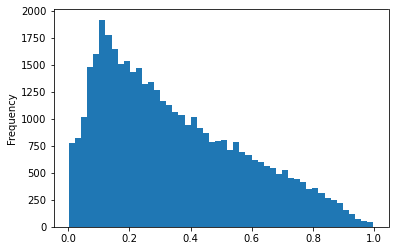

In [32]:
plot_prediction(X, y)

The most surprising outcome (to me) is how much *uncertainty* there is when looking at the voting preferences of all 
Americans. On average, knowing someone's age, race, gender, educational attainment, and the importance they place in 
religion does *not* make it obvious which candidate that individual supported in the 2016 election. 

The model correctly identifies who an individual supported in the election 3/4 times. 

This is not the end of the analysis, though. The histogram shows the uncertainty in preferences of all voters - but are 
there groups that the model can more accurately predict than others?

**NOTE: Voting groups are not monolithic. The below will discuss voting groups that are more highly correlated with the 
outcome of the 2016 election than the general electorate. To draw further (socio-political) conclusions may likely say
more about the reader than the real world.**

## Black Voters

The model correctly identifies which presidential candidate an individual will support 91% of the time.
average mean: 0.14266341427043297
91.90267876334921% voted for Hillary Clinton in 2016
8.097321236650792% voted for Donald Trump in 2016


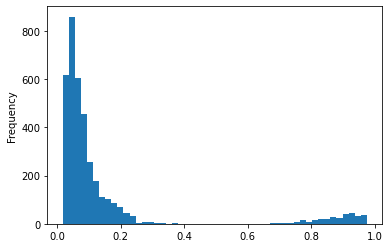

In [33]:
X_black_voters = X[X['race_Black']==1]
y_black_voters = data_final[data_final['race_Black']==1]['CC18_317']

plot_prediction(X_black_voters, y_black_voters)

## Evangelical Voters

The model correctly identifies which presidential candidate an individual will support 82% of the time.
average mean: 0.26378954906016344
29.765947558593055% voted for Hillary Clinton in 2016
70.23405244140694% voted for Donald Trump in 2016


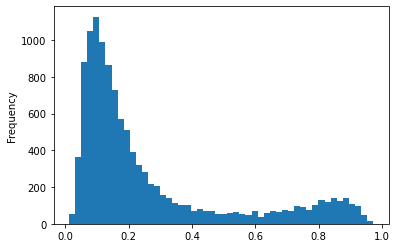

In [34]:
X_evangelical_voters = X[X['pew_bornagain']==1]
y_evangelical_voters = data_final[data_final['pew_bornagain']==1]['CC18_317']

plot_prediction(X_evangelical_voters, y_evangelical_voters)

Are there voters we may be *less* certain about than average? 

## Non-Evangelical White Americans

c:\users\bgagn\pycharmprojects\cces_analysis\venv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
c:\users\bgagn\pycharmprojects\cces_analysis\venv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


The model correctly identifies which presidential candidate an individual will support 68% of the time.
average mean: 0.3970420245760974
57.691325832796814% voted for Hillary Clinton in 2016
42.30867416720319% voted for Donald Trump in 2016


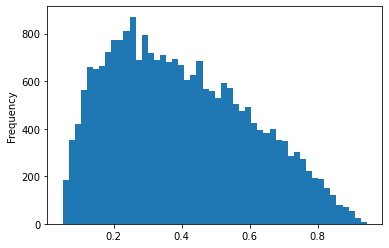

In [35]:
X_white_voters = X[X['race_White']==1][X['pew_bornagain']==2]
y_white_voters = data_final[data_final['race_White']==1][X['pew_bornagain']==2]['CC18_317']

plot_prediction(X_white_voters, y_white_voters)


## People like me

The model correctly identifies which presidential candidate an individual will support 78% of the time.
average mean: 0.305900708415555
68.30033164774662% voted for Hillary Clinton in 2016
31.699668352253386% voted for Donald Trump in 2016


c:\users\bgagn\pycharmprojects\cces_analysis\venv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
c:\users\bgagn\pycharmprojects\cces_analysis\venv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


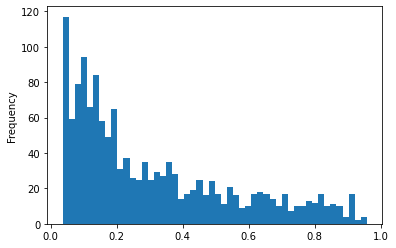

In [36]:
X_me_voters = X[X['race_White']==1][X['educ']==5][X['age']>20][X['age']<30]
y_me_voters = data_final[X['race_White']==1][X['educ']==5][X['age']>20][X['age']<30]['CC18_317']

plot_prediction(X_me_voters, y_me_voters)